# Monter Carlo test for the Kolmogorov-Smirnov test in Python

Piotr Nowicki  
2024-11-14

The Kolmogorv-Smirnov (KS) test, along with other goodness-of-fit tests,
assumes that the parameters of a distribution are provided a priori.
However, these parameters are often estimated in practice. When
parameters are estimated, the calculated p-values from the KS test may
be innacurate. To obtain correct p-values, we can conduct a Monte Carlo
test. This involves drawing samples from an assumed distribution and
obtaining the distribution of the KS statistic or p-value under
parameter estimation. This work provides an example of using the Monte
Carlo test to correct the KS test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Random number generators
rng = np.random.default_rng(20)

# Number of simulations
N = 100000

Prepare data

In [2]:
# Suppose data come from N(5, 2) when the null hypothesis is true
norm_sims = stats.norm(loc=5, scale=2).rvs(size=30*N, random_state=rng).reshape((N, 30))

# Suppose data come from a gamma distribution when the alternative hypothesis is true
gamma_sims = stats.gamma(a=9, loc=0, scale=1/2).rvs(size=30*N, random_state=rng).reshape((N, 30))

P-value distributions when parameters are known

In [3]:
# P-value distribution when the null hypothesis is true
pvals_true = map(lambda x: stats.ks_1samp(x, stats.norm.cdf, (5, 2)).pvalue, norm_sims)
pvals_true = np.fromiter(pvals_true, dtype=np.float64)

# How many p-values are below the threshold?
err_true_rate = np.mean(pvals_true < 0.05)

# P-value distribution when the null hypothesis is false
pvals_false = map(lambda x: stats.ks_1samp(x, stats.norm.cdf, (5, 2)).pvalue, gamma_sims)
pvals_false = np.fromiter(pvals_false, dtype=np.float64)

# How many p-values are below the threshold?
err_false_rate = np.mean(pvals_false < 0.05)

Uncorrected p-value distributions when parameters are unknown

In [4]:
# P-value distribution when the family is true
pvals_true_uncorrected = map(lambda x: stats.ks_1samp(x, stats.norm.cdf, (np.mean(x), np.std(x, ddof=1))).pvalue, norm_sims)
pvals_true_uncorrected = np.fromiter(pvals_true_uncorrected, dtype=np.float64)

# How many p-values are below the threshold?
err_true_rate_uncorrected = np.mean(pvals_true_uncorrected < 0.05)

# P-value distribution when the family is false
pvals_false_uncorrected = map(lambda x: stats.ks_1samp(x, stats.norm.cdf, (np.mean(x), np.std(x, ddof=1))).pvalue, gamma_sims)
pvals_false_uncorrected = np.fromiter(pvals_false_uncorrected, dtype=np.float64)

# How many p-values are below the threshold?
err_false_rate_uncorrected = np.mean(pvals_false_uncorrected < 0.05)

Corrected p-value distributions when parameters are unknown

In [5]:
# Simulate data from a referenced distribution and calculate p-values
ref_sims = stats.norm(0, 1).rvs(size=30*N, random_state=rng).reshape((N, 30))
pval_distr = map(lambda x: stats.ks_1samp(x, stats.norm.cdf, (np.mean(x), np.std(x, ddof=1))).pvalue, ref_sims)
pval_distr = np.fromiter(pval_distr, dtype=np.float64)

# Calculate p-value for your data and compare to the obtained p-value distribution above
pvals_true_corrected = np.mean(pval_distr < pvals_true_uncorrected[:, None], axis=0)

# How many p-values are below the threshold?
err_true_rate_corrected = np.mean(pvals_true_corrected < 0.05)

# Repeat as above but suppose your data come from the gamma distribution
pvals_false_corrected = np.mean(pval_distr < pvals_false_uncorrected[:, None], axis=0)

# How many p-values are below the threshold?
err_false_rate_corrected = np.mean(pvals_false_corrected < 0.05)

Visualisation of the p-value distributions

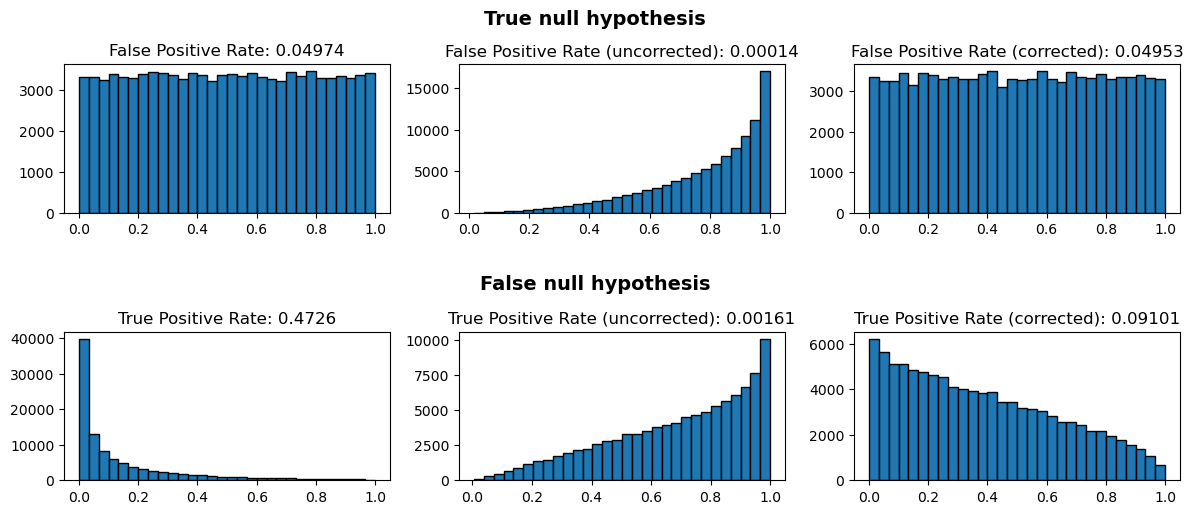

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(12, 5))

fig.text(0.5, 1, "True null hypothesis", ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.5, 0.47, "False null hypothesis", ha='center', va='center', fontsize=14, weight='bold')

ax[0, 0].hist(pvals_true, bins=30, edgecolor='black')
ax[0, 0].set_title(f"False Positive Rate: {err_true_rate}")

ax[0, 1].hist(pvals_true_uncorrected, bins=30, edgecolor='black')
ax[0, 1].set_title(f"False Positive Rate (uncorrected): {err_true_rate_uncorrected}")

ax[0, 2].hist(pvals_true_corrected, bins=30, edgecolor='black')
ax[0, 2].set_title(f"False Positive Rate (corrected): {err_true_rate_corrected}")

ax[1, 0].hist(pvals_false, bins=30, edgecolor='black')
ax[1, 0].set_title(f"True Positive Rate: {err_false_rate}")

ax[1, 1].hist(pvals_false_uncorrected, bins=30, edgecolor='black')
ax[1, 1].set_title(f"True Positive Rate (uncorrected): {err_false_rate_uncorrected}")

ax[1, 2].hist(pvals_false_corrected, bins=30, edgecolor='black')
ax[1, 2].set_title(f"True Positive Rate (corrected): {err_false_rate_corrected}")

plt.tight_layout()
plt.subplots_adjust(top=0.91, hspace=0.8)